# Basics of Image reduction Solutions

**Tutorial by:**<br>
` Harsh Kumar (CFA)`

## Main Motive
Understanding the standard telescope data and making it ready for further science analysis. This step is usually termed as calibraing the pre-processing of the data.


## Key steps
- Understanding the data acquisition.
- Handling fits files.
- Pre-processing RAW images using bias and flat fields. 

**A few important things before we get started:-**
- python3 environment is recommended for this notebook with the following modeules insatlled: (you can also make use of conda to make such an environment.)
- numpy
- matplotlib
- astropy
- photutils

If any of these modules are not installed, a simple pip insatll might do the job. i.e.  `pip install <module>`. You can also use conda to install these modules if you are working in a conda environment. If you are working with conda environment, you might want to make sure that your environment is active and pip is insatlled within your working conda environment to your conda environment

**We also require a few additional astrometic software dependency :-**
- SExtractor   https://www.astromatic.net/software

## Let's get started
We will first import all necessary modules and do some important checks!

! pip install astroquery
! pip install astroscrappy
! pip install astropy
! pip install photutils

In [1]:
# Importing all necessary modules
import os
import glob
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import photutils
import astroscrappy

In [2]:
import subprocess

In [3]:
def check_dependency(dep, i, alternate_names):
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("{} is installed as {}.".format(dep, dep))
        return 0
    except:
        try:
            subprocess.check_output(alternate_names[i], stderr=subprocess.PIPE, shell=True)
            print("{} is installed as {}.".format(dep, alternate_names[i]))
            return 0
    
        except subprocess.CalledProcessError:
            output = "{} is not installed properly.".format(dep)
            n_len = len(output)
            print("%s"%("-" * n_len))
            print(output)
            print("%s"%("-" * n_len))
            return 1
    
dependencies = ['sextractor','psfex']
Alt_names = ['sex', 'PSFEx']
for i, dep in enumerate(dependencies):
    status = check_dependency(dep, i, Alt_names)
    if status != 0:
        print("Dependency is not insatlled properly. Please check for alternative names for dependency or contact the tutors for help.")
else:
    print("All set. Let's fly :-) ")

sextractor is installed as sex.
psfex is installed as psfex.
All set. Let's fly :-) 


Where is your data sitting? For this notebook, keep all of the given files in the folder 'data' in the directory where you're running this notebook.
Directory structure should be:

- CurrentWorkingDirectory <br>
    - data <br>
        - bias <br>
        - flats <br>
        - science <br>

# mounting google drive to import data files
from google.colab import drive
drive.mount('/content/drive')

In [40]:
cwd = "."

# Assigning names for all folders
bias_path = os.path.join(cwd,'data','bias')
flat_path = os.path.join(cwd,'data','flats')
science_path = os.path.join(cwd,'data','science')

os.chdir(cwd)
# os.mkdir('reduced') #creates new folder in \content
reduced_path = os.path.join(cwd,'data','reduced')

In [41]:
# A simple function to check whether some directory exists or not. Useful while using these scripts on new data.
def do_path_check(path_list):
    a_exist = [f for f in path_list if os.path.isdir(f)]
    not_exist=list(set(a_exist) ^ set(path_list))
    print("The following directories exists:\n {} \n".format(a_exist))
    if len(not_exist) > 0:
        print("Please check the path you have given for {}.\n \nIt does not exist!!! \n".format(not_exist))
        return 
    else:
        print("All paths exist. \n")

In [42]:
def make_folder_check(path):
    if os.path.exists(path):
        print("{} Directory exists.".format(path.split("/")[-1]))
    else:
        print("{} does not exist.".format(path))

In [43]:
make_folder_check(bias_path)
make_folder_check(flat_path)
make_folder_check(science_path)
make_folder_check(reduced_path)

bias Directory exists.
flats Directory exists.
science Directory exists.
reduced Directory exists.


In [44]:
# Making a list for the available data. Useful reference. 
bias_list = glob.glob(bias_path +'/*.fits')
flat_list = glob.glob(flat_path +'/*.fits')
sci_list = glob.glob(science_path +'/*wcs.fits')
print("Number of bias frames avaialble: {}".format(len(bias_list)))
print("Number of flat frames avaialble: {}".format(len(flat_list)))
print("Number of science frames avaialble: {}".format(len(sci_list)))

Number of bias frames avaialble: 3
Number of flat frames avaialble: 3
Number of science frames avaialble: 4



# Getting started with fits files

Most of the astronomical images are stored in the form of Flexible Image Transport System (FITS) files. FITS files provide a great option for storing the observational metadata as well as pixel data. With the multi-extension functionality these can be used to store multiple headers and data araays in a single file. 

More info about fits file system can be found here: https://fits.gsfc.nasa.gov/fits_primer.html

Let's spend a few minutes with fits file handling. We will be using a bias image for this purpose (nothing special about a bias image, this will work with any other image as well). 

In [45]:
bias_list[0]

'./data/bias/C0_20181013-130440-460.fits'

In [46]:
test_hdu = fits.open(bias_list[0])
# Let's check the hdu info
test_hdu.info()

Filename: ./data/bias/C0_20181013-130440-460.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   (4096, 4108)   int16 (rescales to uint16)   



### HDUs
Header/Data Units (HDUs) contains both header and data. There can be multiple extensions which can contain multiple headers and multiple data arrays. All the relevent information about the data is stored in headers of the hdu. 

As we can see in the output of the last cell, there is just one extension i.e. PrimaryHDU. Let's go ahead and access the data and header stored there.

In [47]:
test_data = test_hdu[0].data
test_header = test_hdu[0].header
test_hdu.close() # Not necessary, but always a good practice to close the hdu.

In [48]:
test_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                 4108                                                  
HISTORY Created with RTS2 version 0.9.5 build on Jun  3 2018 11:23:41.          
CTIME   =           1539435880 / exposure start (seconds since 1.1.1970)        
USEC    =               460269 / exposure start micro seconds                   
JD      =      2458405.0448033 / Modified Julian Date                           
DATE-OBS= '2018-10-13T13:04:40.460' / start of exposure                         
EXPOSURE=  0.00100000004749745 / exposure length in seconds                     
EXPTIME =  0.00100000004749745 / exposure length in seconds                     
INSTRUME= 'RTS2 spectograph'

In [49]:
# Printing the first 3 entries in the header:
print(test_header[:3])

# You can also print individual key values as following:

x_len = test_header["NAXIS1"]
y_len = test_header["NAXIS2"]

print("\nThe give image size is {} x {} pixels".format(x_len, y_len))

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   16 / array data type                                NAXIS   =                    2 / number of array dimensions                     END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

# Exercise 1

Try to get the following parameters of the image: 
`DATE-OBS, EXPTIME, CCD-TEMP, IMAGETYP, ALTITUDE`

In [50]:
# Let's see the basic image statistics.
mean = np.mean(test_data)
median = np.median(test_data)
std = np.std(test_data)
max_data = np.max(test_data)
min_data = np.min(test_data)
print("max: {%0.2f}"%(max_data))
print("min : {%0.2f}"%(min_data))
print("median: {%0.2f}"%(median))
print("mean: {%0.2f}"%(mean))
print("std: {%0.2f}"%(std))

max: {1744.00}
min : {3.00}
median: {270.00}
mean: {269.67}
std: {9.14}


In [15]:
test_data

array([[251, 268, 255, ..., 269, 259, 261],
       [273, 276, 276, ..., 267, 260, 257],
       [276, 280, 255, ..., 249, 253, 258],
       ...,
       [298, 287, 270, ..., 270, 276, 264],
       [269, 279, 278, ..., 272, 268, 264],
       [281, 269, 269, ..., 276, 267, 265]], dtype=uint16)

# Visualising the data

Text(0, 0.5, 'Number of Pixels')

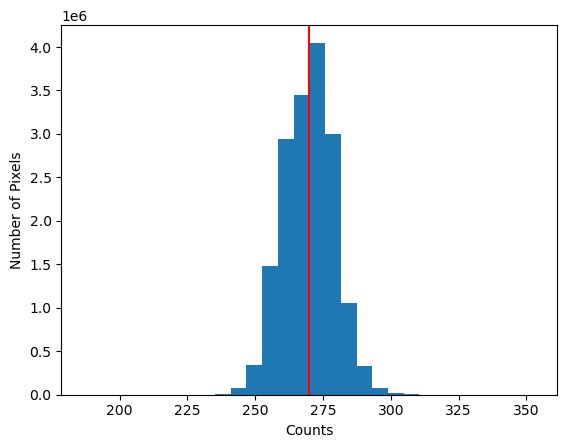

In [16]:
# Let's plot a histogram to understand this distribution
# Plot a histogram with a 10-sigma cut from the median. 

image_hist = plt.hist(test_data.flatten(), bins = 300)
plt.xlim(median - 10*std,median + 10*std)
plt.axvline(x = median, color = 'r')
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')

Now let's have a actual look at the image itself using matplotlib tools. 
This can be done easily using `plt.imshow`. But before that let's set up the matplotlib for nicer visualisation.

In [51]:
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('axes', labelweight='bold')
plt.rc('font', family='sans-serif')

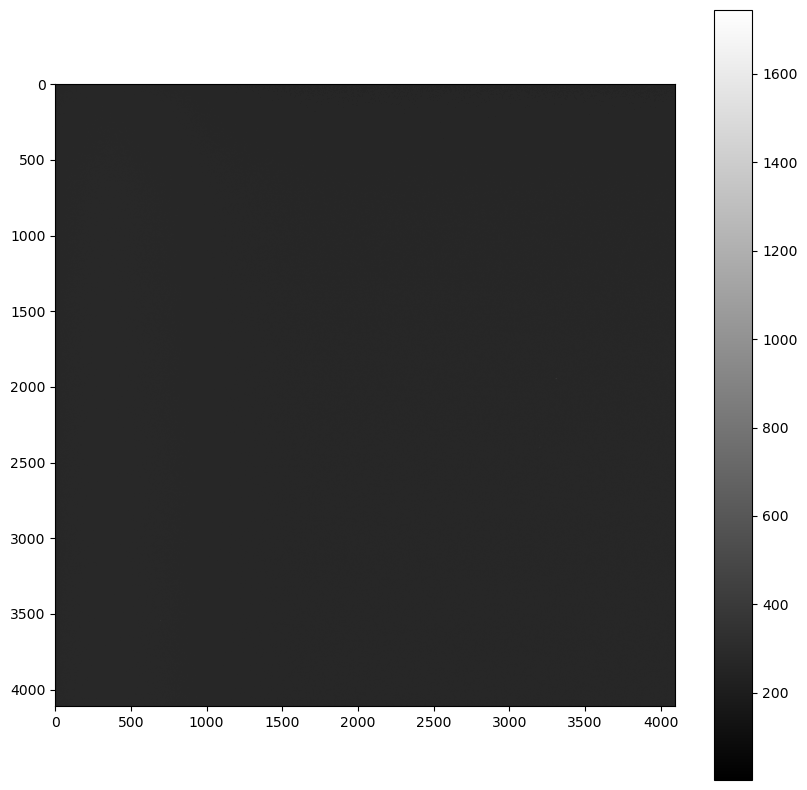

In [52]:
fig = plt.figure( figsize = (10,10))
plt.imshow(test_data, cmap = 'gray')
plt.colorbar()

Ahh!!! this is certainly not what you were expecting, right? <br>
So now what we can do to improve the visibility of image? 
Hint: look at the colorbar scale and statstics of image. 

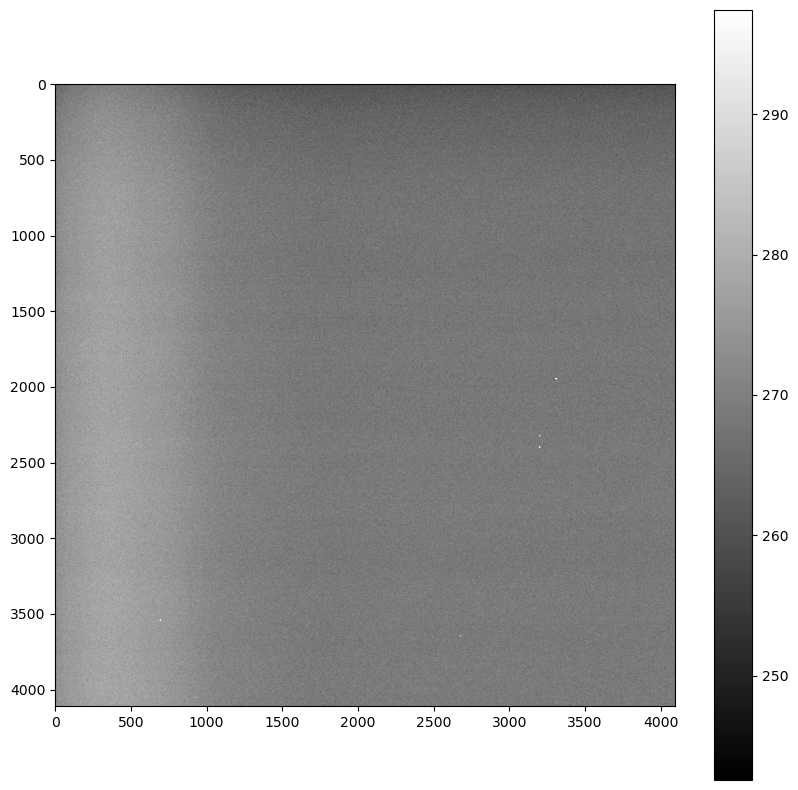

In [19]:
fig = plt.figure( figsize = (10,10))
plt.imshow(test_data, cmap = 'gray', vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()

In [53]:
# Combining median frame to create a master frame

def median_combine_frames(img_list):
    x_len = fits.getval(img_list[0], 'NAXIS2')
    y_len = fits.getval(img_list[0], 'NAXIS1')
    n_images = len(img_list)
    all_frames = np.empty((n_images, x_len, y_len))
    for i in range(n_images):
        all_frames[i,:,:] = fits.open(img_list[i])[0].data
    master_img = np.median(all_frames, axis=0)
    return master_img

Now create a Master Bias! Don't forget to understand every line in the function above. 

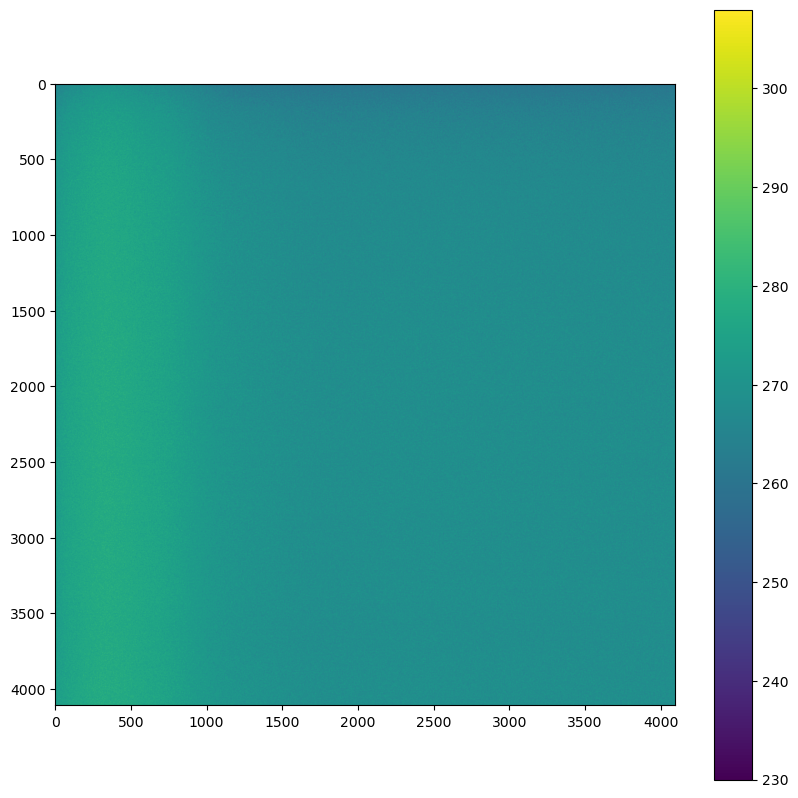

In [54]:
# Creating a Master Bias
master_bias = median_combine_frames(bias_list)
plt.figure(figsize = (10,10))
plt.imshow(master_bias)
plt.colorbar()

# AWESOME! This looks good. 
If not, ask your tutor where you are going wrong. 

Did you notice that the earlier image required us to set scales manually, while the masterbias image shows good scaling automatically? 
What changed? 
Are you never required to set scales for a masterbias?


# Let's make a masterflat.
There are a couple of things you should keep in mind. 

We use flat frames to correct for pixel response. This response function depends on the wavlength of light and hence depends on which filter we used for that image. So, it is required that we make masterflats for individual filters in practice. You all need not to worry though, we have given you all images of same filter and you can always verify. You already know how to check that.  <br>

The other thing you should think about is that do you need to correct flats using masterbias before combining ?

# So, this bring us this the next exercise !!!

Let's make a masterflat in same manner as we have made a masterbias frame. 

In [55]:
# Read the flat header & data 

flat_hdu = fits.open(flat_list[0])
flat_data = flat_hdu[0].data
flat_header = flat_hdu[0].header
flat_hdu.close() # not necessary. But, always a good practice to close the hdu. 


# Exercise
Print stats of all flats to verify that they are useable or not. We will discard the 'bad' flats if necessary.

In [56]:
for i in range(len(flat_list)):
        flat_data = fits.open(flat_list[i])[0].data
        print("Median counts for image_{} is : {}".format(i, np.median(flat_data)))

Median counts for image_0 is : 21433.0
Median counts for image_1 is : 18860.0
Median counts for image_2 is : 15086.0


After verifying that all flats are good, we will now combine them to create a master-flat. You have already combined bias images to create a master-bias. 

In [57]:
def flat_combine(img_list, master_bias):
    x_len = fits.getval(img_list[0], 'NAXIS2')
    y_len = fits.getval(img_list[0], 'NAXIS1')
    n_images = len(img_list)
    all_frames = np.empty((n_images, x_len, y_len))
    for i in range(n_images):
        flat_data = fits.open(img_list[i])[0].data - master_bias
        all_frames[i,:,:] = flat_data / (np.median(flat_data[500:3500, 500:3500]))
    master_img = np.median(all_frames, axis=0)
    return master_img

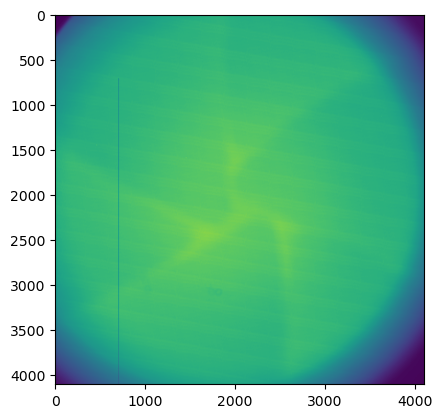

In [58]:
plt.imshow(flat_data)

0.9569094376578526


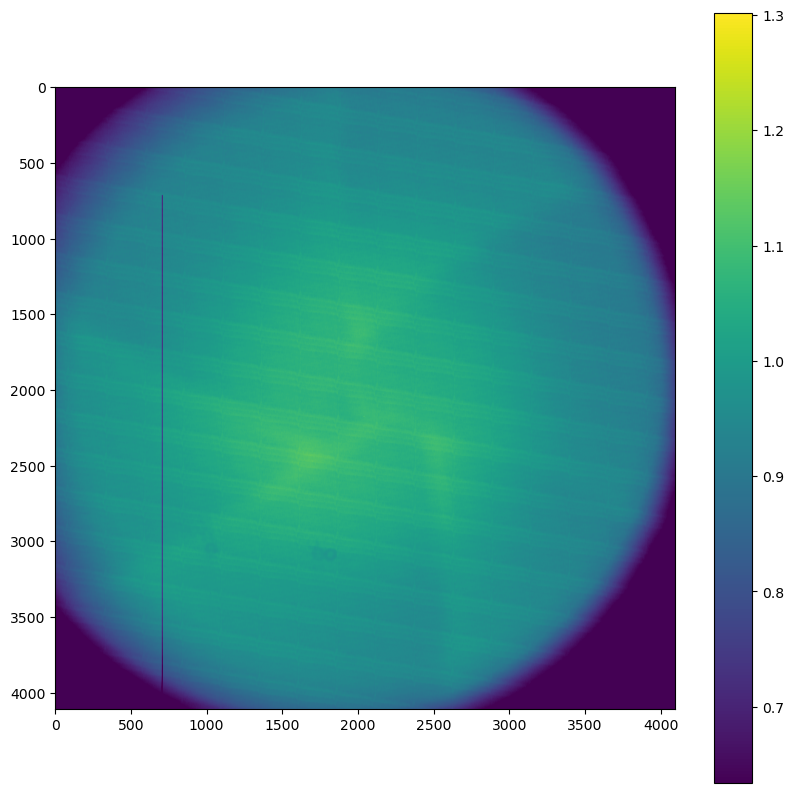

In [26]:
master_flat = flat_combine(flat_list, master_bias)
print(np.median(master_flat))
mean_f, median_f, std_f = sigma_clipped_stats(master_flat)

fig = plt.figure(figsize = (10,10))
plt.imshow(master_flat, vmin = median_f - 5*std_f, vmax = median_f + 5*std_f)
plt.colorbar()

Are you able to see some pattern in the image? Well!! if you look carefully, there are 2 patterns in this image.

Can you tell us what could be the possible reasons behind these patterns?

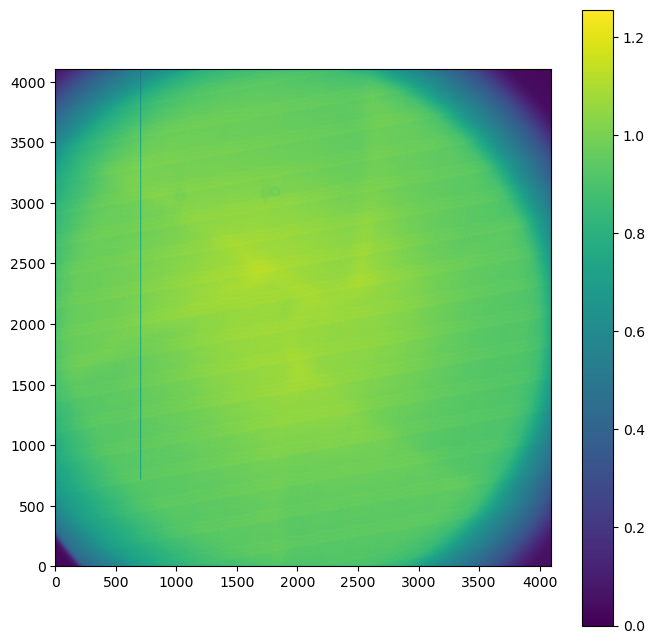

In [59]:
## Set the unexposed pixels to NaN, and display again

master_flat_norm = np.copy(master_flat)*1.0   # Use 'copy' to preserve the original masterFlat

if np.any(master_flat < 0.8):
        # Set all flat-field values lower than 0.2 to NaN
        mask = np.where(master_flat < 0.8) 
        
plt.figure(figsize=(8,8))
plt.imshow(master_flat_norm, origin='lower', vmin = 0)
plt.colorbar()
plt.show()

In [28]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

for i in range(len(sci_list)):
        # Read in the FITS data.
        sci_hdu = fits.open(sci_list[i])
        sci_data = sci_hdu[0].data
        sci_header = sci_hdu[0].header
        # Finally! Bias and flat corrections - The big step that we have been working for so far!
        fbcr_data = (sci_data - master_bias) / master_flat_norm      
        new_hdu = fits.PrimaryHDU(fbcr_data)                    
        new_hdu.header = sci_header                         
        new_hdu.header.add_history('Bias corrected') 
        new_hdu.header.add_history('Flat field corrected')
        # Save the reduced image to a fits file
        try:
            new_hdu.header.remove('BZERO')
            new_hdu.header.remove('BSCALE')
        except:
            print("No BZERO, BSCALE keyword found ")
        fbcr_filename = sci_list[i].split("/")[-1].replace('fits','fb.fits')
        new_hdu.writeto(os.path.join(reduced_path, fbcr_filename), overwrite=True)

['./data/reduced/C0_20181013-201128-360.wcs.fb.fits', './data/reduced/C0_20181013-183430-709.wcs.fb.fits', './data/reduced/C0_20181013-174714-557.wcs.fb.fits', './data/reduced/C0_20181013-190734-760.wcs.fb.fits']


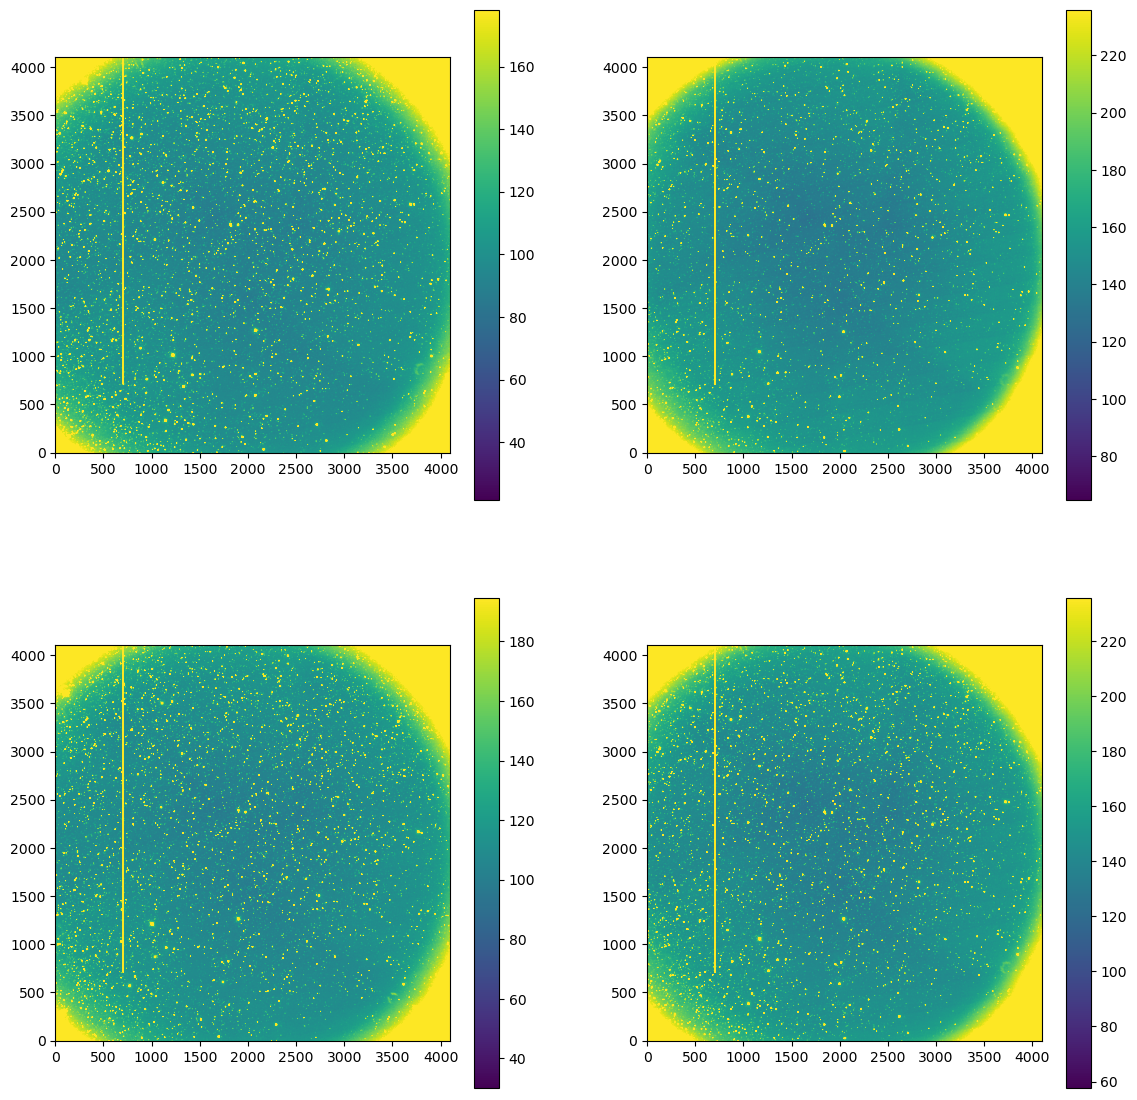

In [29]:
# Let's see how the processed science images look.

fbproc_list = glob.glob(reduced_path + "/*fb.fits") # list of all flat, bias corrected files. 
print(fbproc_list)
plt.figure(figsize=(14,14))
for i in range(len(fbproc_list)):
        procHDU = fits.open(fbproc_list[i])
        procData = procHDU[0].data
        procHDU.close()
        mean, median, std = sigma_clipped_stats(procData)
        plt.subplot(2,2,1+i)
        plt.imshow(procData, vmin = median - 5*std, vmax = median + 5*std, origin='lower')
        plt.colorbar()
plt.show()

### Now on to the final stage of the pre-processing: Cosmic ray removal! 

You might already know that cosmic rays are chared particals protons and nuclei. These charged particles move through space with velocity nearly the speed of light. These produce a shower of secondary particles as soon as they hit the upper layer of the earth's atmosphere. Charged particles intract in different way as compared to the photons. They deposit most of their energy in very small area and can have different profiles in CCD image. We use this cretireia to differentiate them from astrophysical sources.

`lacosmic` is one of the best available algorithm to identify various types of cosmic ray hits. We are going to use the python package `astroscrappy` (https://astroscrappy.readthedocs.io/en/latest/) which is based on the above mentioned algorithm. 

In [30]:
Gain = 1.6 # electrons / ADU
read_noise = 14.0 # electrons
saturation = 96000 # electrons

for i in range(len(fbproc_list)):
    fbproc_hdu = fits.open(fbproc_list[i])
    fbproc_data = fbproc_hdu[0].data
    fbproc_header = fbproc_hdu[0].header
    med = np.median(fbproc_data)
    new_data = np.copy(fbproc_data)
    cosmic_mask, clean_data = astroscrappy.detect_cosmics(new_data, gain=Gain, readnoise=read_noise, satlevel=saturation)
    print('{} pixels are affected by cosmic rays for file {}'.format(np.sum(cosmic_mask), fbproc_list[i].split("/")[-1]))
    proc_data = clean_data / Gain
    
    if np.any(master_flat < 0.8):
        proc_data[mask] = med # Correcting for the vignetting region 

    proc_header = fbproc_header
    proc_header.add_history('Cosmic ray removed') 
    cleaned_image = fbproc_list[i].replace("fb.fits", "proc.fits")
    fits.writeto(cleaned_image, proc_data, proc_header, overwrite=True)

142414 pixels are affected by cosmic rays for file C0_20181013-201128-360.wcs.fb.fits
87100 pixels are affected by cosmic rays for file C0_20181013-183430-709.wcs.fb.fits
126874 pixels are affected by cosmic rays for file C0_20181013-174714-557.wcs.fb.fits
98025 pixels are affected by cosmic rays for file C0_20181013-190734-760.wcs.fb.fits


In [31]:
# Plot the cleaned_image below and see whether the vignetting region is still present.

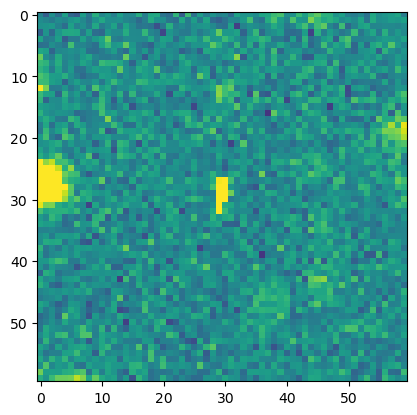

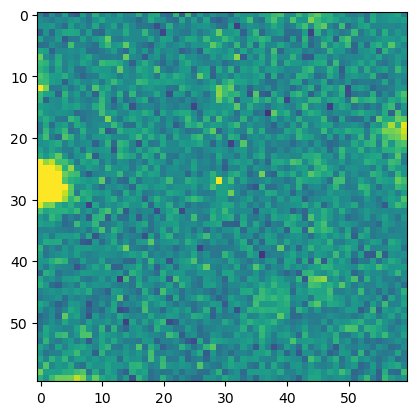

In [36]:
# Let's check if the cosmic ray correction worked or not. 

boxsize = 30

pix_2 = 1796
pix_1 = 2085


_, m1, std1 = sigma_clipped_stats(fbproc_data[pix_1 -boxsize:pix_1+boxsize, pix_2-boxsize:pix_2+boxsize])
_, m2, std2 = sigma_clipped_stats(proc_data[pix_1 -boxsize:pix_1+boxsize, pix_2-boxsize:pix_2+boxsize])

plt.imshow(fbproc_data[pix_1-boxsize:pix_1+boxsize, pix_2-boxsize:pix_2+boxsize], vmin = m1-5*std1, vmax = m1 + 5*std1)
plt.show()
plt.imshow(proc_data[pix_1-boxsize:pix_1+boxsize, pix_2-boxsize:pix_2+boxsize], vmin = m2-5*std2, vmax = m2 + 5*std2)

The above mention three step (bias correction, flat fielding and cosmic ray removal) are most common operation of pre-processing. Although, depending on each telescope facility there might be other operations can be done in pre-processing. Such corrections are not applicable for general use as these operation are usually telescope faciity specific. 

Sometimes astronomers try to take multiple short exposures and stack the images to get better S/N ratio. This also help in getting rid of comsic ray removal step. Spend a minute thinking why we can skip cosmic ray removal part after stacking (see home exercise at the end of notebook) the image?

After all these corrections, we usually perform one more step i.e. solving image for astrometry.
You must be thinking what does that means?  

When we take images through telescope facility, the camera stores photons numbers in each pixels. It has no information of where the photons are coming from. Although the telescope pointing software usaully gives rough estimate of direction, but it is impossible to associate the photons of each pixel to aspecific part of sky. During solving images for astrometry we establish a unique realtion between image pixels and sky coordinates. This allos us to identify sources in the image.

This step require astrometry.net's `solve-field` engine to solve the images (you can download it from here [https://astrometry.net/use.html], if you are interested) with the help of index files. These indexfiles are rather large ~ 50GB in total. We have provided you astrometry-solved images to avoid this heavy download. Alternate option is to upload image on the publically available online server of astrometry.net here: [https://nova.astrometry.net/upload] and download the solved images from there.  
*Important Note*:- You might want to login first and then change a few advanced settings in order to keep your 
data private. Otherwise uploaded images will be publicly available.

# Take Home Exercise

All these images are processed and ready to use for science use. As we have multiple science images for the same field, we can try to stack (a process of combining images - imagine stacking boxes on top of each other) them to make an image with better S/N ratio. The most commonly used software for this is SWarp. Here is the documentation for SWarp [https://www.astromatic.net/pubsvn/software/swarp/trunk/doc/swarp.pdf]. you can go into details of how to combine images and try yourself. 

In [30]:
# Try it out by yourself!